除了batch和mini-batch外的对比实验都在基于sklearn的实现中完成了
这边不再重复实验，只注重于通过numpy的手写实现

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import random

In [2]:
df_train = pd.read_csv('dataset/train.tsv', sep='\t')
df_test = pd.read_csv('dataset/test.tsv', sep='\t')

In [3]:
df_train = df_train.head(1000)

In [4]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [5]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()


def preprocess_sentence(df):
    for i in range(len(df)):
        sentence = re.sub(r'[^\w\s]', '', df['Phrase'][i].lower())  #删除单词字符(a-zA-Z0-9_)和空白符外的所有字符
        words = nltk.word_tokenize(sentence)
        words_clean = [word for word in words if not word in stop_words and len(word) > 3]  #删除停用词(包括长度<=2的)
        sentence_clean = ''
        for word in words_clean:
            sentence_clean += str(lemmatizer.lemmatize(word)) + ' '  #词形还原
        yield sentence_clean

In [6]:
df_train['phrase_clean'] = list(preprocess_sentence(df_train))
df_test['phrase_clean'] = list(preprocess_sentence(df_test))

In [7]:
X_train_text = df_train['phrase_clean'].values
y_train = df_train['Sentiment'].values
X_test_text = df_test['phrase_clean'].values
X_train_text.shape, y_train.shape, X_test_text.shape

((1000,), (1000,), (66292,))

In [8]:
class BagofWords:
    def __init__(self):
        self.word2idx = {}
        self.vocab_size = 0

    def fit(self, sent_list):
        for sent in sent_list:
            words = sent.strip().split(' ')
            for word in words:
                if word not in self.word2idx:
                    self.word2idx[word] = len(self.word2idx)
        self.vocab_size = len(self.word2idx)

    def transform(self, sent_list):
        features = np.zeros((len(sent_list), self.vocab_size))
        for idx, sent in enumerate(sent_list):
            words = sent.strip().split(' ')
            for word in words:
                features[idx][self.word2idx[word]] += 1
        return features

In [9]:
class Ngram:
    def __init__(self, ngram):
        self.ngram = ngram
        self.gram2idx = {}
        self.ngram_size = 0

    def fit(self, sent_list):
        for num in self.ngram:
            for sent in sent_list:
                sent = sent.split(' ')
                for i in range(len(sent) - num + 1):
                    gram = ' '.join(sent[i:i + num])
                    if gram not in self.gram2idx:
                        self.gram2idx[gram] = len(self.gram2idx)
        self.ngram_size = len(self.gram2idx)

    def transform(self, sent_list):
        features = np.zeros((len(sent_list), self.ngram_size))
        for idx, sent in enumerate(sent_list):
            sent = sent.split(' ')
            for num in self.ngram:
                for i in range(len(sent) - num + 1):
                    gram = ' '.join(sent[i:i + num])
                    if gram in self.gram2idx:
                        features[idx][self.gram2idx[gram]] += 1
        return features

In [10]:
ngram = Ngram(ngram=(3, 3))
ngram.fit(X_train_text)
X_train = ngram.transform(X_train_text)
y_train = y_train.reshape(-1, 1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def softmax(z):
    z = np.exp(z)
    z /= np.sum(z, axis=1, keepdims=True)
    return z


class SoftmaxRegression():
    def __init__(self, epochs=100, learning_rate=0.01, num_classes=5, batch_size=None):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_features = None
        self.num_classes = num_classes
        self.W = None

    def fit(self, X, y, epochs=100, learning_rate=0.01, num_classes=5, batch_size=None):
        '''

        :param X: (batch_size, num_features)
        :param y: (batch_size, 1)
        :param W: (num_classes, num_features)
        :return loss_history: (iters, )

        '''
        self.__init__(epochs, learning_rate, num_classes, batch_size)
        if self.batch_size is None:
            self.batch_size, self.num_features = X.shape
        else:
            _, self.num_features = X.shape
        self.W = np.random.randn(self.num_classes, self.num_features)
        batch_pos = [i for i in range(0, X.shape[0], self.batch_size)]
        batch_num = len(batch_pos)
        batch_pos.append(X.shape[0])

        y_onehot = np.zeros((X.shape[0], self.num_classes))
        for i in range(X.shape[0]):
            y_onehot[i][y[i]] = 1

        loss_history = []
        for epoch in range(epochs):
            for t in range(batch_num):
                loss = 0
                X_t = X[batch_pos[t]:batch_pos[t + 1]]
                y_t = y[batch_pos[t]:batch_pos[t + 1]]
                y_t_onehot = y_onehot[batch_pos[t]:batch_pos[t + 1]]
                batch_size = batch_pos[t + 1] - batch_pos[t]
                probs = softmax(X_t @ self.W.T)
                for i in range(batch_size):
                    loss -= np.log(probs[i][y_t[i]])
                grad = np.zeros_like(self.W)
                for i in range(batch_size):
                    grad += (y_t_onehot[i] - probs[i]).reshape(1, self.num_classes).T @ X_t[i].reshape(1,
                                                                                                       self.num_features)
                self.W += grad * self.learning_rate / batch_size
                loss /= batch_size
                loss_history.append(loss)

        return loss_history

    def predict(self, X):
        probs = softmax(X @ self.W.T)
        return probs.argmax(axis=1)

    def score_acc(self, X, y):
        pred = self.predict(X)
        return np.sum(pred.reshape(y.shape) == y) / y.shape[0]

### batch与mini-batch对比实验

In [12]:
epochs = 1000
seed = 42
random.seed(seed)
np.random.seed(seed)
model = SoftmaxRegression()
loss_history = model.fit(X_train, y_train, epochs=epochs)
model.score_acc(X_val, y_val)

0.125

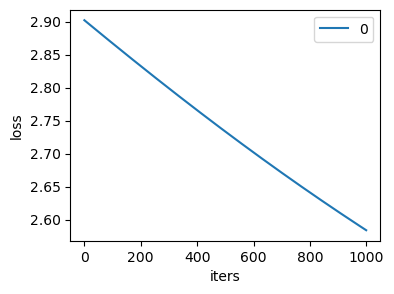

In [13]:
loss_history = np.array(loss_history)
plt.figure(figsize=(4, 3))
ax = sns.lineplot(data=loss_history)
ax.set_xlabel("iters")
ax.set_ylabel("loss")
plt.show()

In [14]:
batch_size = 32
random.seed(seed)
np.random.seed(seed)
model = SoftmaxRegression()
loss_history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
model.score_acc(X_val, y_val)

0.24

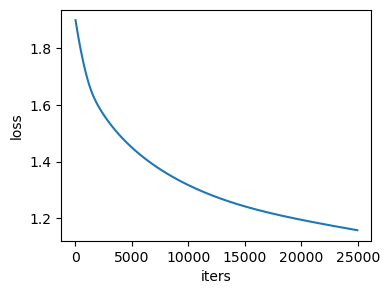

In [15]:
log_step = 50
loss_history = np.array(loss_history).flatten()
x = np.arange(0, len(loss_history), log_step)
y = loss_history[x]
plt.figure(figsize=(4, 3))
ax = sns.lineplot(x=x, y=y)
ax.set_xlabel("iters")
ax.set_ylabel("loss")
plt.show()

结论：一次梯度下降未必需要那么多样本，这就是mini-batch的意义。同样的iter下batch肯定更好，同样的epochs下，mini-batch的iter就很多了，因此一般会更好，但是缺点是可能在最优点附近振荡